# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

2024-10-01 20:03:05.455863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 20:03:05.456060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 20:03:05.575634: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 20:03:05.816918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 20:03:07.588264: W tensorflow/compiler/tf2

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
tokenizer = Tokenizer()  # Create a new Tokenizer object
tokenizer.fit_on_texts(corpus)  # Fit the tokenizer on the corpus

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
total_words = len(tokenizer.word_index) + 1  # Get the total number of unique words
print(f"Total vocabulary size: {total_words}")

Total vocabulary size: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [5]:
input_sequences = []  # Empty list to store the sequences

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]  # Convert each line to a sequence of integers
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]  # Create n-gram sequences
        input_sequences.append(n_gram_sequence)  # Add the sequence to the list

# Print the first few sequences to inspect
print(input_sequences[:5])


[[3, 2], [3, 2, 313], [3, 2, 313, 1375], [3, 2, 313, 1375, 4], [118, 1376]]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [6]:
max_sequence_len = max([len(seq) for seq in input_sequences])
print(f"Max sequence length: {max_sequence_len}")

input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

input_sequences = np.array(input_sequences)

print(f"Padded input sequences shape: {input_sequences.shape}")


Max sequence length: 11
Padded input sequences shape: (15484, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [7]:

predictors = input_sequences[:, :-1]  # All elements except the last one
labels = input_sequences[:, -1]       # The last element is the label


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [8]:

labels = ku.to_categorical(labels, num_classes=total_words)

print(f"Predictors shape: {predictors.shape}")
print(f"Labels shape: {labels.shape}")


Predictors shape: (15484, 10)
Labels shape: (15484, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [9]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    # Embedding layer
     Embedding(input_dim=total_words, output_dim=100),

    # Bidirectional LSTM layer
    Bidirectional(LSTM(150, return_sequences=True)),

    # Dropout layer to prevent overfitting
    Dropout(0.2),

    # Another LSTM layer
    LSTM(100),

    # Dense layer (Intermediate) with L2 regularization
    Dense(total_words // 2, activation='relu', kernel_regularizer=l2(0.01)),

    # Output dense layer with softmax activation
    Dense(total_words, activation='softmax')
])


2024-10-01 20:03:11.818737: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-01 20:03:12.242106: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-01 20:03:12.242371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [10]:
# Step 9: Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [11]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         337500    
                                                                 
 bidirectional (Bidirection  (None, None, 300)         301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1687)              170387    
                                                                 
 dense_1 (Dense)             (None, 3375)              5697000   
                                                        

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [12]:
history = model.fit(predictors, labels, epochs=50, verbose=1)


2024-10-01 20:03:17.671313: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209034000 exceeds 10% of free system memory.
2024-10-01 20:03:17.967066: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209034000 exceeds 10% of free system memory.


Epoch 1/50


2024-10-01 20:03:25.312126: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-10-01 20:03:26.658648: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff4180a7030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-01 20:03:26.658722: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-10-01 20:03:26.687108: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727813006.838417      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


484/484 [==============================] - 21s 23ms/step - loss: 6.9169 - accuracy: 0.0199
Epoch 2/50
484/484 [==============================] - 5s 11ms/step - loss: 6.5047 - accuracy: 0.0237
Epoch 3/50
484/484 [==============================] - 5s 10ms/step - loss: 6.4141 - accuracy: 0.0254
Epoch 4/50
484/484 [==============================] - 5s 10ms/step - loss: 6.2922 - accuracy: 0.0296
Epoch 5/50
484/484 [==============================] - 5s 10ms/step - loss: 6.1951 - accuracy: 0.0354
Epoch 6/50
484/484 [==============================] - 5s 10ms/step - loss: 6.1110 - accuracy: 0.0382
Epoch 7/50
484/484 [==============================] - 5s 9ms/step - loss: 6.0320 - accuracy: 0.0409
Epoch 8/50
484/484 [==============================] - 5s 9ms/step - loss: 5.9453 - accuracy: 0.0440
Epoch 9/50
484/484 [==============================] - 5s 10ms/step - loss: 5.8431 - accuracy: 0.0521
Epoch 10/50
484/484 [==============================] - 5s 10ms/step - loss: 5.7341 - accuracy: 0.0563
E

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

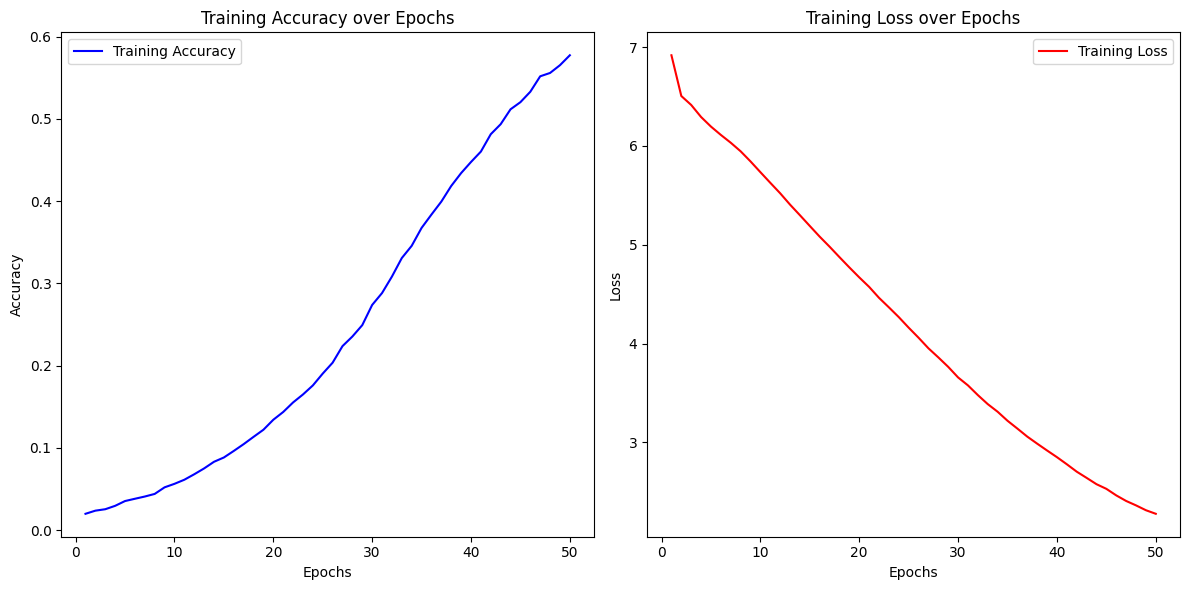

In [17]:
import matplotlib.pyplot as plt

# Step 11: Plot training accuracy and loss over epochs

# Extract the history data for accuracy and loss
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [19]:
seed_text = "Shall I compare thee to a summer's day"
next_words = 50 

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [21]:
for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Pad the tokenized sequence to match the input length
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word (highest probability)
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)
    
    # Find the word corresponding to the predicted index
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

print(seed_text)


Shall I compare thee to a summer's day fitted staineth staineth staineth quite gone can go did light deceive light light light go ill slow quite light tell her near dwells alive do be hate up that gems cross'd hate yourself and loving place rare 'will ' can speed speed speed see renew'd counted part do me behold it now show thee open slow kept used than day disdain date part ' quite light burn be disdain dyed quite light twain light quite place 'tis new hour than glory so told i dwell in woe grow quite asleep clearer light light warm'd warm'd light quite mother light alive


Experiment with at least 3 different seed_text strings and see what happens!

In [22]:
seed_text = "what's the time, honey?"
next_words=10

In [25]:
for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Pad the tokenized sequence to match the input length
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word (highest probability)
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)
    
    # Find the word corresponding to the predicted index
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

print(seed_text)


what's the time, honey? infant's distemper'd than painted asleep hate lies used pride lies


In [26]:
seed_text = "what are you talking about, Liscisca? "
next_words=10

In [27]:
for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Pad the tokenized sequence to match the input length
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word (highest probability)
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)
    
    # Find the word corresponding to the predicted index
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

print(seed_text)

what are you talking about, Liscisca?  fairer lodged and lovely deep fall her wind broken decrease


In [29]:
seed_text = "Girl you're coocko "
next_words=10

In [30]:
for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Pad the tokenized sequence to match the input length
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word (highest probability)
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)
    
    # Find the word corresponding to the predicted index
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

print(seed_text)

Girl you're coocko  not prizing her a woman woos make woman's son dwell
